In [1]:
# 📦 설치 (처음 1회만 실행)
!pip install transformers scikit-learn pandas openpyxl tqdm

In [2]:
# 📚 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm

In [3]:
# 📂 실험 데이터 로드
df = pd.read_excel("sentences_for_probing_break_freeze_updated.xlsx")

In [4]:
# 🔍 프레임 유형이 10개 이상인 것만 사용
counts = df["frame_type"].value_counts()
valid_classes = counts[counts >= 10].index.tolist()
df = df[df["frame_type"].isin(valid_classes)].reset_index(drop=True)

# 🎯 준비
sentences = df["sentence"].tolist()
verb_indices = df["verb_index"].tolist()
labels = df["frame_type"].tolist()
control_labels = df["control_frame_label"].tolist()

# 데이터 분할
sentences_train, sentences_test, labels_train, labels_test = train_test_split(
    sentences, labels, test_size=0.2, random_state=42, stratify=labels
)

# control_labels도 동일한 기준으로 분할합니다.
control_labels_train, control_labels_test = train_test_split(
    control_labels, test_size=0.2, random_state=42, stratify=control_labels
)

real_sentences = sentences_train
control_sentences = sentences_train # Assuming control sentences are the same as real for simplicity

y_real_train = labels_train
y_real_test = labels_test
y_control_train = control_labels_train
y_control_test = control_labels_test

In [5]:
# 🤖 RoBERTa 모델 및 tokenizer 불러오기
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
model = RobertaModel.from_pretrained("roberta-large", output_hidden_states=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  

In [6]:
import torch
from transformers import RobertaTokenizer, RobertaModel

def extract_all_layer_outputs(model, tokenizer, sentences):
    model.eval()
    all_layer_outputs = []

    for sent in tqdm(sentences, desc="Extracting Features"):
        inputs = tokenizer(sent, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[1:] # Exclude embeddings layer
            # For each layer, perform mean pooling
            layer_outputs = [h.squeeze(0).mean(dim=0).cpu().numpy() for h in hidden_states]
            all_layer_outputs.append(layer_outputs)

    # Transpose the list to get a list of outputs per layer
    # all_layer_outputs[layer_index][sentence_index][feature_dimension]
    all_layer_outputs_transposed = list(map(list, zip(*all_layer_outputs)))

    return [np.array(layer_output_list) for layer_output_list in all_layer_outputs_transposed]

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm # tqdm import

layers_to_check = [1, 6, 12, 18, 24] # RoBERTa-large has 24 layers (0-23). Use 1-based indexing for consistency with the paper.
# Adjusting layers_to_check to match 0-based indexing for hidden_states:
layers_to_check_0_based = [layer - 1 for layer in layers_to_check]


acc_list, f1_real_list, f1_control_list, selectivity_list = [], [], [], []

# 데이터 분할 기준을 저장 (sentences_train과 sentences_test의 길이)
train_size = len(sentences_train)
test_size = len(sentences_test)

# 전체 데이터에 대해 모든 레이어 representation을 한 번에 추출
all_sentences = sentences_train + sentences_test
all_layer_features = extract_all_layer_outputs(model, tokenizer, all_sentences)


for layer_0_based in tqdm(layers_to_check_0_based, desc="Probing Layers"):
    layer = layer_0_based + 1 # Convert back to 1-based for printing

    # 추출된 feature를 훈련 세트와 테스트 세트로 분할
    # all_layer_features[layer_0_based] contains features for all sentences for this layer
    X_real_all = all_layer_features[layer_0_based]
    X_control_all = all_layer_features[layer_0_based] # Assuming control sentences are the same as real for feature extraction


    X_real_train = X_real_all[:train_size]
    X_real_test = X_real_all[train_size:]

    X_control_train = X_control_all[:train_size]
    X_control_test = X_control_all[train_size:]


    # Logistic Regression 훈련
    clf_real = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
    clf_control = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')

    clf_real.fit(X_real_train, y_real_train)
    clf_control.fit(X_control_train, y_control_train)

    # 예측 및 평가
    preds_real = clf_real.predict(X_real_test)
    preds_control = clf_control.predict(X_control_test)

    acc = accuracy_score(y_real_test, preds_real)
    f1_real = f1_score(y_real_test, preds_real, average='macro')
    f1_control = f1_score(y_control_test, preds_control, average='macro')
    selectivity = f1_real - f1_control

    acc_list.append(acc)
    f1_real_list.append(f1_real)
    f1_control_list.append(f1_control)
    selectivity_list.append(selectivity)

    print(f"✅ Layer {layer}: Acc={acc:.3f}, F1_real={f1_real:.3f}, F1_control={f1_control:.3f}, Selectivity={selectivity:.3f}")

Probing Layers:  20%|██        | 1/5 [00:02<00:08,  2.08s/it]

✅ Layer 1: Acc=0.762, F1_real=0.730, F1_control=0.137, Selectivity=0.593


Probing Layers:  40%|████      | 2/5 [00:04<00:06,  2.10s/it]

✅ Layer 6: Acc=0.866, F1_real=0.847, F1_control=0.126, Selectivity=0.721


Probing Layers:  60%|██████    | 3/5 [00:06<00:04,  2.10s/it]

✅ Layer 12: Acc=0.891, F1_real=0.879, F1_control=0.134, Selectivity=0.745


Probing Layers:  80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

✅ Layer 18: Acc=0.879, F1_real=0.863, F1_control=0.123, Selectivity=0.741


Probing Layers: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

✅ Layer 24: Acc=0.874, F1_real=0.861, F1_control=0.150, Selectivity=0.710


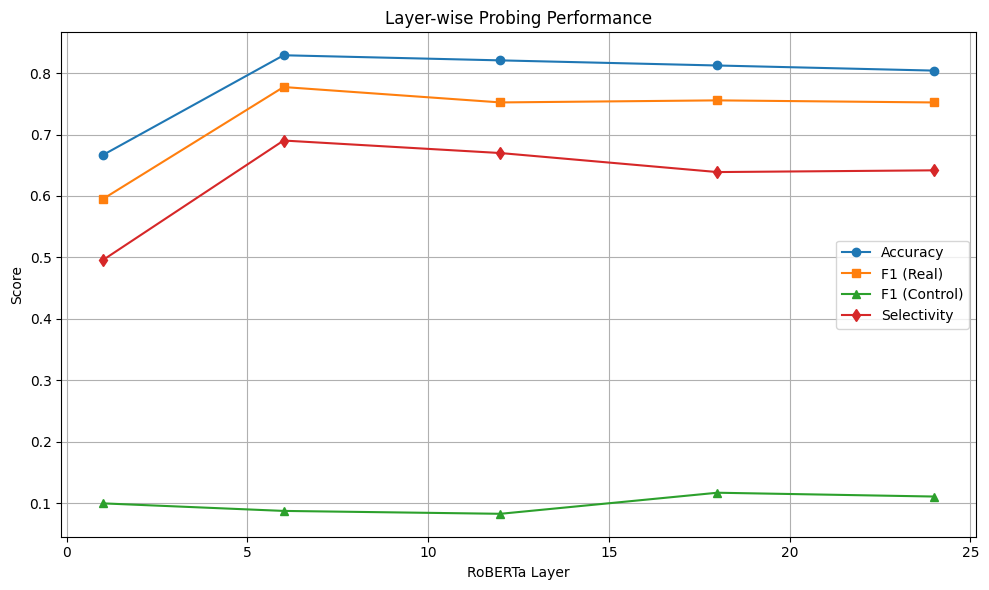

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(layers_to_check, acc_list, marker='o', label='Accuracy')
plt.plot(layers_to_check, f1_real_list, marker='s', label='F1 (Real)')
plt.plot(layers_to_check, f1_control_list, marker='^', label='F1 (Control)')
plt.plot(layers_to_check, selectivity_list, marker='d', label='Selectivity')
plt.title("Layer-wise Probing Performance")
plt.xlabel("RoBERTa Layer")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("layerwise_probe_plot.png")
plt.show()

In [ ]:
# 저장
df_result = pd.DataFrame({
    'Layer': layers_to_check,
    'Accuracy': acc_list,
    'F1_Real': f1_real_list,
    'F1_Control': f1_control_list,
    'Selectivity': selectivity_list
})
df_result.to_csv("layerwise_probe_scores.csv", index=False)


# Layer 24에 대한 예측 결과 추가 및 저장
# 전체 데이터셋에 대한 layer 24의 feature 추출
# Use the pre-extracted features for layer 24 (which is index 23 in 0-based indexing)
X_real_all_layer_24 = all_layer_features[23] # 24th layer corresponds to index 23

# Layer 24 모델 훈련 (전체 훈련 데이터 사용)
clf_real_layer_24 = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
# Need to split the extracted features for training
X_real_train_layer_24 = X_real_all_layer_24[:train_size]
clf_real_layer_24.fit(X_real_train_layer_24, y_real_train)


# 전체 데이터셋에 대한 예측
preds_real_layer_24 = clf_real_layer_24.predict(X_real_all_layer_24)

# 결과를 원본 데이터프레임에 추가
df_output = df.copy()
df_output['gold_label'] = labels
df_output['predicted_label'] = preds_real_layer_24
df_output['correct'] = df_output['gold_label'] == df_output['predicted_label']

# content 폴더에 새로운 파일로 저장
df_output.to_excel("/content/sentences_with_predictions_layer24.xlsx", index=False)

print("Layer 24 예측 결과가 'sentences_with_predictions_layer24.xlsx' 파일로 저장되었습니다.")

Layer 24 예측 결과가 'sentences_with_predictions_layer24.xlsx' 파일로 저장되었습니다.
